In [1]:
# import necessary libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import kagglehub
import optuna
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
# Constants
ROOT = kagglehub.dataset_download("nasrulhakim86/coughvid-wav") + '/public_dataset/'
AUDIO_LENGTH = 22050

def load_dataset(take=None):
    print(f'Using dataset from {ROOT}')
    json_files = []
    for file in os.listdir(ROOT):
        if file.endswith('.json'):
            with open(os.path.join(ROOT, file)) as f:
                json_data = json.load(f)
                json_data['uuid'] = file.split('.')[0]
                json_files.append(json_data)

    df = pd.DataFrame(json_files)
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    if take is not None:
        df = df.head(take)

    df['cough_detected'] = df['cough_detected'].astype(float)

    # drop null status
    df = df[df.status.notna()]
    # drop cough_detected < 0.8
    df = df[df.cough_detected >= 0.8]
    return df

In [4]:
def segment_cough(x, fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier=0.1, th_h_multiplier=2):
    # Initialize cough mask and calculate RMS-based thresholds
    cough_mask = np.array([False] * len(x))
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms  # Lower threshold for cough detection
    seg_th_h = th_h_multiplier * rms  # Higher threshold for cough detection

    # Initialize variables for cough detection
    cough_segments = []
    padding = round(fs * cough_padding)  # Convert padding to samples
    min_cough_samples = round(fs * min_cough_len)  # Convert minimum length to samples
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01 * fs)  # Tolerance for noise
    below_th_counter = 0

    # Process audio signal to detect coughs
    for i, sample in enumerate(x ** 2):
        if cough_in_progress:
            # Check if signal drops below lower threshold
            if sample < seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    # End of cough detected
                    cough_end = i + padding if (i + padding < len(x)) else len(x) - 1
                    cough_in_progress = False
                    # Add segment if it meets minimum length requirement
                    if cough_end + 1 - cough_start - 2 * padding > min_cough_samples:
                        cough_segments.append(x[cough_start:cough_end + 1])
                        cough_mask[cough_start:cough_end + 1] = True
            # Handle end of signal
            elif i == (len(x) - 1):
                cough_end = i
                cough_in_progress = False
                if cough_end + 1 - cough_start - 2 * padding > min_cough_samples:
                    cough_segments.append(x[cough_start:cough_end + 1])
            else:
                below_th_counter = 0
        else:
            # Check for start of new cough
            if sample > seg_th_h:
                cough_start = i - padding if (i - padding >= 0) else 0
                cough_in_progress = True

    return cough_segments, cough_mask

In [5]:
def extract_features(audio_data, sample_rate):
    
    features = []
    
    # Compute Short-time Fourier transform
    stft = np.abs(librosa.stft(audio_data))

    # Extract MFCC features (40 coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
    features.extend(mfcc)

    # Extract chroma features (12 features representing musical notes)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features.extend(chroma)

    # Extract mel spectrogram features (128 mel bands)
    mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T, axis=0)
    features.extend(mel)

    # Calculate minimum frequency for spectral contrast
    min_val = 0.5 * sample_rate * 2 ** (-6)
    # Extract spectral contrast features
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, fmin=min_val).T, axis=0)
    features.extend(contrast)

    return np.array(features)

In [6]:
def load_features(df):
    # Initialize empty lists to store features and filenames
    features, filenames = [], []
    
    # Iterate through each row in the dataframe
    for idx in tqdm(range(len(df))):
        # Get filename from uuid column
        filename = df.uuid.iloc[idx]
        path = os.path.join(ROOT + filename + '.wav')

        # Load audio file and get sample rate
        audio, sample_rate = librosa.load(path, mono=True)
        # Segment cough sounds from audio
        cough_segments, cough_mask = segment_cough(audio, sample_rate, min_cough_len=0.1, cough_padding=0.1,
                                                   th_l_multiplier=0.1, th_h_multiplier=2)

        # Process each cough segment if any were found
        if len(cough_segments) > 0:
            i = 0
            for audio in cough_segments:
                i += 1
                # Only process segments longer than 8000 samples
                if len(audio) > 8000:
                    # Pad or truncate audio to fixed length
                    if len(audio) < AUDIO_LENGTH:
                        audio_pad = librosa.util.pad_center(audio, size=AUDIO_LENGTH)
                    else:
                        audio_pad = audio[:AUDIO_LENGTH]

                # Extract features from processed audio segment
                feature = extract_features(audio_pad, sample_rate)
                features.append(feature)
                filenames.append(filename)

    # Return arrays of filenames and their corresponding features
    return np.array(filenames), np.array(features)

In [7]:
def aggregate_features(processed_df, uuid, X):
    # Split features into different types based on their indices
    x_mfcc = X[:, 0:40]  # MFCC features (first 40 columns)
    x_chroma = X[:, 40:52]  # Chroma features (next 12 columns)
    x_mel = X[:, 52:180]  # Mel spectrogram features (next 128 columns)
    x_contrast = X[:, 180:]  # Spectral contrast features (remaining columns)

    # Create DataFrame for UUIDs
    uuid_df = pd.DataFrame({'uuid': uuid})
    
    # Create and name columns for MFCC features
    mfcc_df = pd.DataFrame(x_mfcc)
    mfcc_df.columns = ["mfcc" + str(i) for i in range(1, x_mfcc.shape[1] + 1)]

    # Create and name columns for Mel spectrogram features
    mel_df = pd.DataFrame(x_mel)
    mel_df.columns = ["mel" + str(i) for i in range(1, x_mel.shape[1] + 1)]

    # Create and name columns for Chroma features
    chroma_df = pd.DataFrame(x_chroma)
    chroma_df.columns = ["chr" + str(i) for i in range(1, x_chroma.shape[1] + 1)]

    # Create and name columns for Spectral contrast features
    contrast_df = pd.DataFrame(x_contrast)
    contrast_df.columns = ["con" + str(i) for i in range(1, x_contrast.shape[1] + 1)]

    # Combine all feature DataFrames
    all_df = pd.concat([uuid_df, mfcc_df, mel_df, chroma_df, contrast_df], axis=1)
    
    # Get status labels from processed dataframe
    label_df = processed_df[['uuid', 'status']].reset_index(drop=True)

    # Merge features with labels
    dataset = pd.merge(all_df, label_df, on='uuid')
    
    # Remove unknown status entries
    dataset = dataset[dataset.status != 'unknown']
    
    # Balance the dataset by sampling equal number of samples from each status
    dataset = dataset.groupby('status').sample(n=2185)

    return dataset

In [8]:
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss function
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix using true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a new figure with specified size
    plt.figure(figsize=(8, 6))
    
    # Create heatmap visualization of confusion matrix
    # annot=True shows numbers in cells, fmt='d' formats as integers, cmap='Blues' sets color scheme
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Set plot title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Display the plot
    plt.show()

In [10]:
def plot_roc_curve(y_true, y_pred_prob):
    # Calculate ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with specified size
    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve with AUC score in label
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    
    # Add legend and grid
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [11]:
class DenseNet(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout_rate):
        super(DenseNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Creating hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_dim, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_size
            
        # Output layer
        layers.extend([
            nn.Linear(prev_dim, 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [12]:
def objective(trial, X, y):
    # Number of layers as a hyperparameter
    n_layers = trial.suggest_int('n_layers', 2, 6)
    
    # Hidden layer sizes
    hidden_sizes = []
    for i in range(n_layers):
        size = trial.suggest_int(f'hidden_size_{i}', 32, 512)
        hidden_sizes.append(size)
    
    # Single dropout parameter for all layers
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Remaining hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    epochs = trial.suggest_int('epochs', 5, 30)

    # Data preparation
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    x_train_tensor = torch.FloatTensor(x_train)
    x_test_tensor = torch.FloatTensor(x_test)
    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)
    
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Create model with new hyperparameters
    model = DenseNet(
        input_dim=x_train.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rate=dropout_rate
    )
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_loss

In [13]:
def optimize_hyperparameters(data, n_trials=100):
    # Extract features (X) and target variable (y) from the dataset
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]
    # Convert target labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)
    
    # Create an Optuna study for hyperparameter optimization
    study = optuna.create_study(direction='minimize', study_name="coughvid_analysis")
    # Run optimization trials using the objective function
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    # Print results of the best trial
    print("Best trial:")
    trial = study.best_trial
    
    print("  Value: ", trial.value)
    print("  Params: ")
    # Print all hyperparameters from the best trial
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Return the best hyperparameters found
    return trial.params

In [14]:
def train(data, epochs=50, hyperparams=None):
    # Balance the dataset by sampling equal number of samples from each class
    data.groupby('status').sample(n=2185, replace=True)

    # Extract features and target variable
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]
    # Convert target labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Convert data to PyTorch tensors
    x_train_tensor = torch.FloatTensor(x_train)
    x_test_tensor = torch.FloatTensor(x_test)
    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)

    # Create PyTorch datasets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    # Set up data loaders
    batch_size = hyperparams['batch_size'] if hyperparams else 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    input_dim = x_train.shape[1]
    
    # Initialize model with hyperparameters if provided, otherwise use default values
    if hyperparams:
        hidden_sizes = []
        for i in range(hyperparams['n_layers']):
            hidden_sizes.append(hyperparams[f'hidden_size_{i}'])
        
        model = DenseNet(
            input_dim=input_dim,
            hidden_sizes=hidden_sizes,
            dropout_rate=hyperparams['dropout_rate']
        )
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
    else:
        model = DenseNet(
            input_dim=input_dim,
            hidden_sizes=[256, 128, 64, 32],
            dropout_rate=0.3
        )
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = nn.BCELoss()

    # Initialize lists to store training metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print('Training model...')
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    # Plot training results
    plot_training_results(train_losses, train_accs, val_losses, val_accs)

    # Save the trained model
    torch.save(model.state_dict(), 'model.pth')

    print('Evaluating model...')
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    # Make predictions on test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.view(-1, 1)
            outputs = model(inputs)
            all_predictions.extend((outputs > 0.5).float().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())

    y_pred = np.array(all_predictions).flatten()
    y_true = np.array(all_labels).flatten()
    y_prob = np.array(all_probabilities).flatten()

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve
    plot_roc_curve(y_true, y_prob)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [15]:
def evaluate_single_sample(data, uuid):
    # Filter data for specific UUID
    df = data[data['uuid'] == uuid]

    # Extract features and labels
    X = df.iloc[:, 1:-1]  # All columns except first and last
    y = df.iloc[:, -1]    # Last column contains labels

    # Convert labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y.values)

    # Create PyTorch dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Initialize model with default architecture
    model = DenseNet(
        input_dim=X.shape[1],
        hidden_sizes=[256, 128, 64, 32],
        dropout_rate=0.3
    )
    # Load trained model weights
    model.load_state_dict(torch.load('model.pth'))

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataset):
            # Get model predictions
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            print('Segment', idx, 'Predicted:', predicted.item(), 'Actual:', labels.item())

In [16]:
# Load and preprocess data from the dataset
processed_df = load_dataset()
print(f'Extracting spectrogram features from {len(processed_df)} waveforms')
# Extract features and UUIDs from the processed data
uuid, x = load_features(processed_df)
# Combine features into a single dataset
dataset = aggregate_features(processed_df, uuid, x)
print(f'Dataset records count: {len(dataset)}')

# Save the processed dataset to CSV for future use
dataset.to_csv('dataset.csv', index=False)



Using dataset from /Users/wiktorraczek/.cache/kagglehub/datasets/nasrulhakim86/coughvid-wav/versions/1/public_dataset/
Extracting spectrogram features from 10553 waveforms


100%|██████████| 10553/10553 [07:01<00:00, 25.03it/s]


Dataset records count: 6555


In [17]:
# Perform hyperparameter optimization to find the best model configuration
print("Starting hyperparameter optimization...")
best_params = optimize_hyperparameters(dataset, n_trials=100)



[I 2025-06-08 13:55:42,240] A new study created in memory with name: coughvid_analysis


Starting hyperparameter optimization...


[I 2025-06-08 13:55:45,606] Trial 0 finished with value: 0.5977517806348347 and parameters: {'n_layers': 5, 'hidden_size_0': 339, 'hidden_size_1': 444, 'hidden_size_2': 97, 'hidden_size_3': 93, 'hidden_size_4': 97, 'dropout_rate': 0.2278886261629346, 'learning_rate': 0.0007851859427150447, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: 0.5977517806348347.
[I 2025-06-08 13:55:46,958] Trial 1 finished with value: 0.6012902882966128 and parameters: {'n_layers': 6, 'hidden_size_0': 206, 'hidden_size_1': 328, 'hidden_size_2': 269, 'hidden_size_3': 78, 'hidden_size_4': 189, 'hidden_size_5': 207, 'dropout_rate': 0.29221575398056027, 'learning_rate': 0.005000219028472041, 'batch_size': 128, 'epochs': 8}. Best is trial 0 with value: 0.5977517806348347.
[I 2025-06-08 13:55:49,714] Trial 2 finished with value: 0.6339677005279355 and parameters: {'n_layers': 3, 'hidden_size_0': 65, 'hidden_size_1': 494, 'hidden_size_2': 393, 'dropout_rate': 0.11992211108910178, 'learning_rate': 1.138

Best trial:
  Value:  0.5765608440745961
  Params: 
    n_layers: 6
    hidden_size_0: 473
    hidden_size_1: 50
    hidden_size_2: 396
    hidden_size_3: 391
    hidden_size_4: 169
    hidden_size_5: 343
    dropout_rate: 0.4532864085668345
    learning_rate: 0.0010314362633555732
    batch_size: 128
    epochs: 23



Training model with optimized hyperparameters...
Training model...
Epoch 1/50, Train Loss: 0.6470, Train Acc: 0.6682, Val Loss: 0.6419, Val Acc: 0.6568
Epoch 2/50, Train Loss: 0.6291, Train Acc: 0.6691, Val Loss: 0.6257, Val Acc: 0.6568
Epoch 3/50, Train Loss: 0.6177, Train Acc: 0.6691, Val Loss: 0.6252, Val Acc: 0.6568
Epoch 4/50, Train Loss: 0.6065, Train Acc: 0.6691, Val Loss: 0.6219, Val Acc: 0.6568
Epoch 5/50, Train Loss: 0.6004, Train Acc: 0.6691, Val Loss: 0.6149, Val Acc: 0.6568
Epoch 6/50, Train Loss: 0.5855, Train Acc: 0.6699, Val Loss: 0.6129, Val Acc: 0.6568
Epoch 7/50, Train Loss: 0.5643, Train Acc: 0.6827, Val Loss: 0.6112, Val Acc: 0.6606
Epoch 8/50, Train Loss: 0.5678, Train Acc: 0.6924, Val Loss: 0.6022, Val Acc: 0.6766
Epoch 9/50, Train Loss: 0.5593, Train Acc: 0.6991, Val Loss: 0.6064, Val Acc: 0.6773
Epoch 10/50, Train Loss: 0.5387, Train Acc: 0.7088, Val Loss: 0.6081, Val Acc: 0.6484
Epoch 11/50, Train Loss: 0.5412, Train Acc: 0.7157, Val Loss: 0.6088, Val Acc: 0.

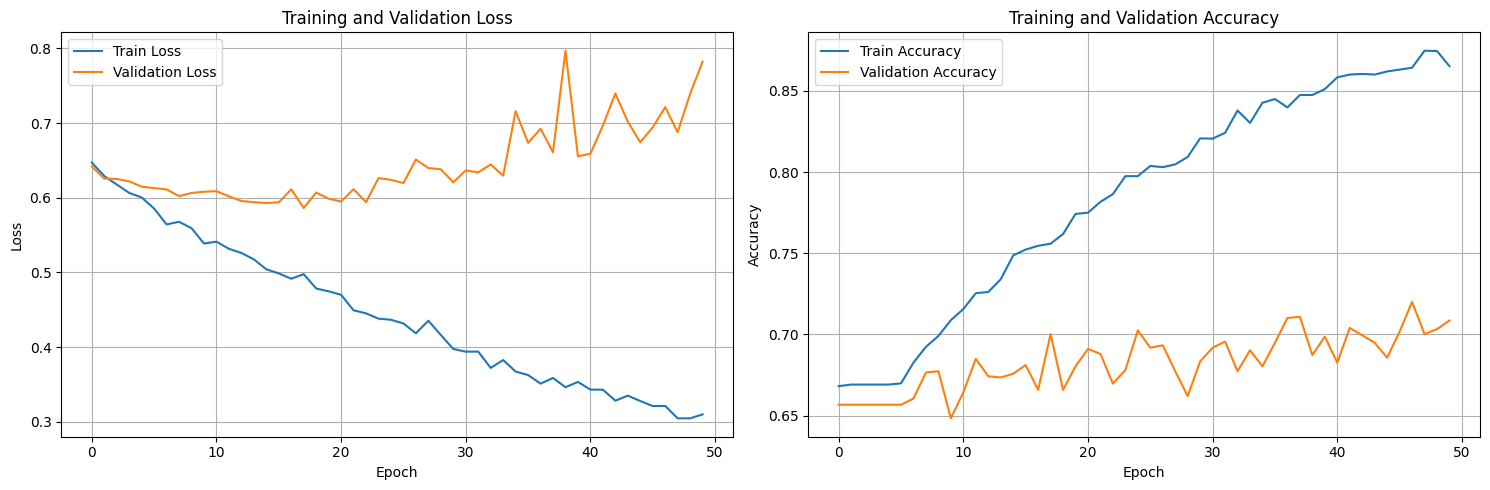

Evaluating model...


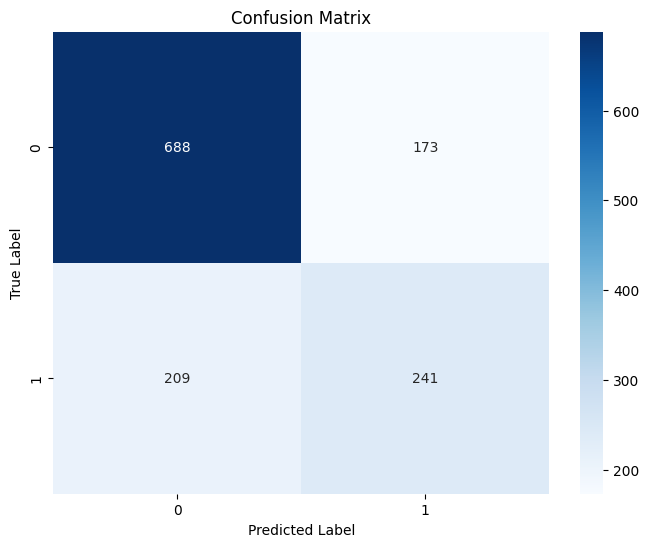

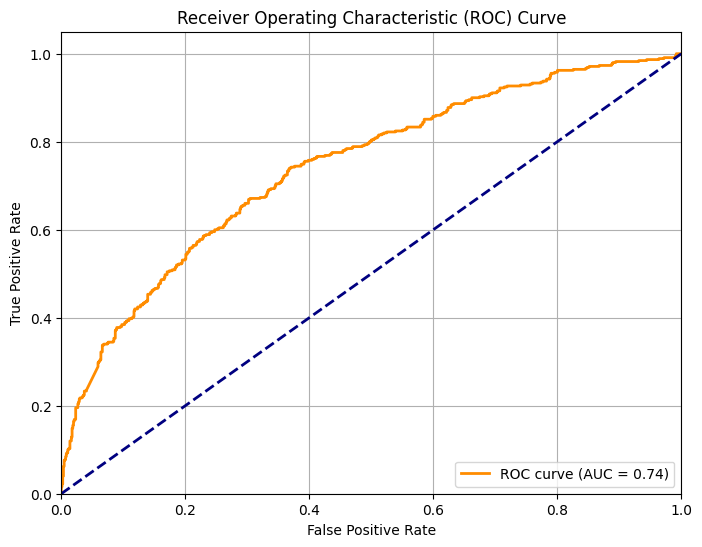


Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       861
         1.0       0.58      0.54      0.56       450

    accuracy                           0.71      1311
   macro avg       0.67      0.67      0.67      1311
weighted avg       0.70      0.71      0.71      1311



In [18]:
# Train the model using the optimized hyperparameters
print("\nTraining model with optimized hyperparameters...")
train(dataset, hyperparams=best_params)

# Cough Audio Classification with Deep Learning

**Dataset**: [CoughVid WAV on Kaggle](https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav)

This repository contains a deep learning pipeline for classifying cough audio recordings using a fully connected neural network. The notebook processes audio data, extracts relevant features, optimizes model performance using Optuna, and evaluates the results using standard classification metrics.

---

## Technologies Used
- Programming Language: Python 3
- Framework: PyTorch
- Audio Processing: librosa
- Data Handling: pandas, numpy
- Visualization: matplotlib
- Hyperparameter Optimization: Optuna
- Dataset Access: kagglehub
- Progress Tracking: tqdm

---

## Pipeline Overview

### 1. Data Loading

The dataset is programmatically downloaded using kagglehub. The pipeline processes 10,553 waveforms and extracts features from cough segments. The final dataset contains 6,555 records after processing.

### 2. Audio Preprocessing

Raw audio files are loaded using librosa. Each audio clip is:
- Segmented using a custom cough detection function based on energy thresholds
- Only segments longer than 8000 samples are processed
- Padded or truncated to a fixed length (AUDIO_LENGTH)

### 3. Feature Engineering

Multiple audio features are extracted:
- MFCC features (40 coefficients)
- Chroma features (12 features representing musical notes)
- Mel spectrogram features (128 mel bands)
- Spectral contrast features

### 4. Model Architecture

The classification model is a feedforward neural network with:
- Input layer matching the feature vector size
- Hidden layers with sizes [256, 128, 64, 32]
- Dropout rate of 0.3 for regularization
- Output layer for binary classification

### 5. Training

The model is trained with:
- Binary cross-entropy loss
- Adam optimizer
- 50 epochs
- Training and validation metrics tracked per epoch

### 6. Evaluation

The model is evaluated on individual segments, comparing predicted vs actual labels for each cough segment.

### 7. Hyperparameter Optimization

Optuna is used to optimize model hyperparameters through 100 trials, focusing on:
- Network architecture
- Learning rate
- Batch size
- Other training parameters

---

## Results

The model achieved:
- Training Accuracy: 86.52%
- Validation Accuracy: 70.86%
- Training Loss: 0.3099
- Validation Loss: 0.7822

These results show good training performance but indicate some overfitting, as the validation metrics are lower than training metrics.

---

## Limitations and Future Work
- The model shows signs of overfitting, suggesting a need for stronger regularization or a simpler architecture
- The current feature extraction process could be optimized for better computational efficiency
- The dataset could benefit from more sophisticated data augmentation techniques
- The model could be extended to handle multi-class classification of different types of coughs
- Real-time processing capabilities could be added for practical applications
- The model could be deployed as a web service for easier access and testing